In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.models import VGG16_Weights, MobileNet_V2_Weights
from PIL import Image
import requests


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/bartek/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/bartek/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/bartek/.local/lib/python3.10/site-pac

In [2]:
# Definiowanie ścieżek do datasetu - lokalnie, potem plan jest taki, żeby pobierało z kaggle
# https://www.kaggle.com/datasets/jarocichociemny420/msc-testdataset
data_dir = '/media/bartek/889CBCD79CBCC14C/msc-testdataset'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'

In [3]:
classes = ('mug', 'parfum')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Cuda dostępna")
else:
    print("Trening na CPU")

Cuda dostępna


In [30]:
# konwersja tensora na obraz
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5)) + np.array((0.5))
    image = image.clip(0, 1)
    return image

In [31]:
# Wczytanie modelu
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)

for param in model.features.parameters():
    param.requires_grad = False

n_inputs = model.classifier[1].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[1] = last_layer

# funkcja kosztu i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Trenowanie modelu
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()

    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
            val_running_loss += val_loss.item()

    epoch_loss = running_loss / len(training_loader.dataset)
    epoch_acc = running_corrects.float() / len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print(f'Epoch {e+1}: Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print(f'Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.4f}')


Epoch 1: Training loss: 0.0322, Accuracy: 0.6870
Validation loss: 0.0377, Validation accuracy: 0.5814
Epoch 2: Training loss: 0.0253, Accuracy: 0.8551
Validation loss: 0.0381, Validation accuracy: 0.6279
Epoch 3: Training loss: 0.0203, Accuracy: 0.9391
Validation loss: 0.0376, Validation accuracy: 0.6279
Epoch 4: Training loss: 0.0186, Accuracy: 0.9217
Validation loss: 0.0381, Validation accuracy: 0.6395
Epoch 5: Training loss: 0.0163, Accuracy: 0.9507
Validation loss: 0.0367, Validation accuracy: 0.6163


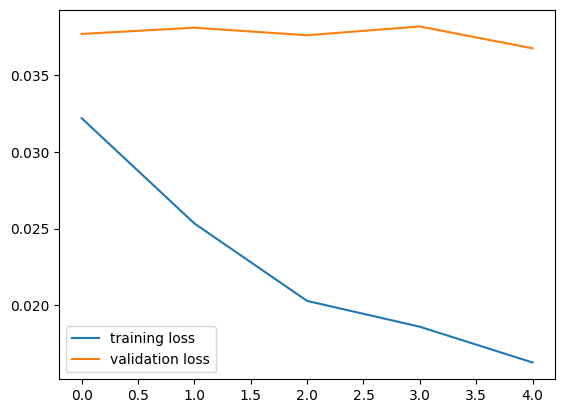

In [32]:
# Wizualizacja wyników treningu
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

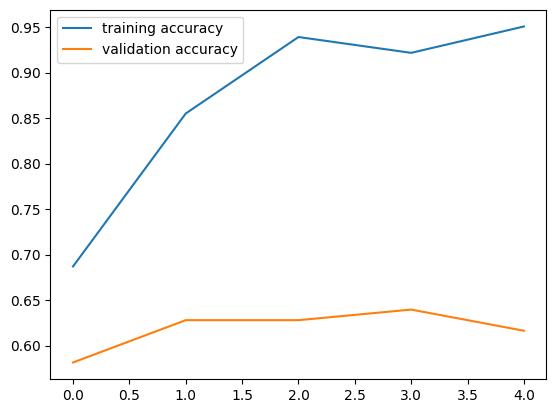

In [33]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [34]:
print(f'Training accuracy: {epoch_acc:.4f}')
print(f'Validation accuracy: {val_epoch_acc:.4f}')

Training accuracy: 0.9507
Validation accuracy: 0.6163


In [36]:
iterations = 20
obj = 'mug'

# mógłbym w sumie testować to na swoich zdjęciach, ale z ciekawości testowałem model na obrazach z internetu
url = 'https://porcelanabydgoszcz.pl/wp-content/uploads/2022/05/Plus-Gold-Kubek-3.jpg'
sum = 0.0

'''
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img = transform(img).unsqueeze(0)
output = model(img)
_, pred = torch.max(output, 1)
print(f'Przewidziany obiekt: {classes[pred.item()]}')
'''

correct_predictions = 0  # Licznik poprawnych predykcji

for i in range(iterations):
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    img = transform(img).unsqueeze(0)
    output = model(img)
    _, pred = torch.max(output, 1)
    # Sprawdzamy czy model poprawnie przewidział obiekt porównując wynik z zadanym obrazem
    if classes[pred.item()] == obj:
        correct_predictions += 1

accuracy = correct_predictions / iterations
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.00
